In [518]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
x_train = pd.read_csv('train_features.tsv', sep = '\t', header = 0)
y_train = pd.read_csv('train_labels.tsv', sep = '\t', header = 0)
x_valid = pd.read_csv('valid_features.tsv', sep = '\t', header = 0)
y_valid = pd.read_csv('valid_labels.tsv', sep = '\t', header = 0)
x_test = pd.read_csv('test_features.csv', sep = ',', header = 0)

In [520]:
x_y_train = x_train.merge(y_train, on = 'movieId')
x_y_valid = x_valid.merge(y_valid, on = 'movieId')

In [521]:
# concatenate to process 'title' and 'tag' together
x_y_train['title_tag'] = x_y_train['title'].str.cat(x_y_train['tag'], sep = ' ', na_rep = '')
x_y_valid['title_tag'] = x_y_valid['title'].str.cat(x_y_valid['tag'], sep = ' ', na_rep = '')
x_test['title_tag'] = x_test['title'].str.cat(x_test['tag'], sep = ' ', na_rep = '')

In [525]:
# drop invalid column
x_y_train.drop(columns=['movieId','YTId','year','avf31', 'avf32','avf104'],inplace=True)
x_y_valid.drop(columns=['movieId','YTId','year','avf31', 'avf32','avf104'],inplace=True)
x_test.drop(columns=['movieId','YTId','year','avf31', 'avf32','avf104'],inplace=True)

In [528]:
punctuation =['bd-r','_',',',')','.',':','&','/','!','\'s','-']
stop_words = ['bd','from','a','an','with','on','and','for','over','episode','of','in','the','aka','of','clv','dvds','dvd','soundtrack','video','i','ii','iii','iv','imdb','film','more','than','once','betamax','great','seen','top','reviewed','predictable','can\'t','remember','ratings','less','overrated','remake','to','afi','based','true','story','adapted','boring','black','white','national','registry','tumey','erlend','book','classic','ram','franchise','cinematography','world','new','york','city','sequel','england','de','la','cast','ensemble','japan','british','chick','flick','night','original','my','life','big','no','me','last','le','house','multiple','storylines','robert','day','at','all','k','bechdel','test','fail','dialogue','bad','acting','man','serial','narrated','it','american','movie','you','is','who','men','part','little','one','woman','street','mr','out','les','first','that','your','three','living','are','under','days','we','what','or','up','o','good','like','not','two','about','this','how','cat','d','another','don\'t','before','after','oscar','criterion']
num_list = ['0','1','2','3','4','5','6','7','8','9']

In [529]:
# for text clean
def textCleaner(df, targetColumn):
    df[targetColumn] = df[targetColumn].str.lower()
    for p in punctuation:
        df[targetColumn] = df[targetColumn].str.replace(p,' ')
    for index,row in df.iterrows():
        tmp_word_list = row[targetColumn].split()
        delete_word_list = []
        for word in tmp_word_list:
            if word in stop_words:
                delete_word_list.append(word)
            if word[0] in num_list:
                delete_word_list.append(word)
        tmp_word_list = [word for word in tmp_word_list if not word in delete_word_list]
        df.at[index, targetColumn] = ' '.join(tmp_word_list)

In [530]:
textCleaner(x_y_train, 'title_tag')
textCleaner(x_y_train, 'tag')
textCleaner(x_y_valid, 'title_tag')
textCleaner(x_y_valid, 'tag')
textCleaner(x_test, 'title_tag')
textCleaner(x_test, 'tag')

In [536]:
# each set divided into three parts: texual, numerical, y_labels 
title_tag_x_train = x_y_train['title_tag']
tag_x_train = x_y_train['tag']
y_train = x_y_train['genres'].values
x_train = x_y_train.drop(columns = ['title','tag','title_tag','genres'])

title_tag_x_valid = x_y_valid['title_tag']
tag_x_valid = x_y_valid['tag']
y_valid = x_y_valid['genres'].values
x_valid = x_y_valid.drop(columns = ['title','tag','title_tag','genres'])

title_tag_x_test = x_test['title_tag']
tag_x_test = x_test['tag']
x_test = x_test.drop(columns = ['title','tag','title_tag'])

In [539]:
# turn 'title' and 'tag' together into matrices
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = None, filters = '')
tokenizer.fit_on_texts(title_tag_x_train.values)
title_tag_x_train_matrix = tokenizer.texts_to_matrix(title_tag_x_train.values)[:,1:]
title_tag_x_valid_matrix = tokenizer.texts_to_matrix(title_tag_x_valid.values)[:,1:]
title_tag_x_test_matrix = tokenizer.texts_to_matrix(title_tag_x_test.values)[:,1:]

In [541]:
# turn 'tag' alone
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = None, filters = '')
tokenizer.fit_on_texts(tag_x_train.values)
tag_x_train_matrix = tokenizer.texts_to_matrix(tag_x_train.values)[:,1:]
tag_x_valid_matrix = tokenizer.texts_to_matrix(tag_x_valid.values)[:,1:]
tag_x_test_matrix = tokenizer.texts_to_matrix(tag_x_test.values)[:,1:]

In [543]:
# discretization of the numerical parts
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
est.fit(x_train)
binary_x_train = est.transform(x_train)
binary_x_valid = est.transform(x_valid)
binary_x_test = est.transform(x_test)

In [544]:
# concatenate the discretized features with the text matrices
# two traing sets prepared
# one with 'title' and one without
title_tag_x_train = pd.concat([pd.DataFrame(binary_x_train), pd.DataFrame(title_tag_x_train_matrix)], axis = 1)
title_tag_x_valid = pd.concat([pd.DataFrame(binary_x_valid), pd.DataFrame(title_tag_x_valid_matrix)], axis = 1)
title_tag_x_test = pd.concat([pd.DataFrame(binary_x_test), pd.DataFrame(title_tag_x_test_matrix)], axis = 1)
tag_x_train = pd.concat([pd.DataFrame(binary_x_train), pd.DataFrame(tag_x_train_matrix)], axis = 1)
tag_x_valid = pd.concat([pd.DataFrame(binary_x_valid), pd.DataFrame(tag_x_valid_matrix)], axis = 1)
tag_x_test = pd.concat([pd.DataFrame(binary_x_test), pd.DataFrame(tag_x_test_matrix)], axis = 1)

title_tag_x_train (5240, 6148)
title_tag_x_train (299, 6148)
title_tag_x_train (235, 6148)
tag_x_train (5240, 313)
tag_x_train (299, 313)
tag_x_train (235, 313)


In [546]:
# dimensionality reduction using pca
from sklearn.decomposition import PCA
title_tag_pca = PCA(n_components= 0.95)
title_tag_pca.fit(title_tag_x_train)
pca_title_tag_x_train = title_tag_pca.transform(title_tag_x_train)
pca_title_tag_x_valid = title_tag_pca.transform(title_tag_x_valid)
pca_title_tag_x_test = title_tag_pca.transform(title_tag_x_test)

tag_pca = PCA(n_components= 0.95)
tag_pca.fit(tag_x_train)
pca_tag_x_train = tag_pca.transform(tag_x_train)
pca_tag_x_valid = tag_pca.transform(tag_x_valid)
pca_tag_x_test = tag_pca.transform(tag_x_test)

Shape of dimension-reduced 'title_tag_x_train' (5240, 470)
Shape of dimension-reduced 'title_tag_x_valid' (299, 470)
Shape of dimension-reduced 'title_tag_x_test' (235, 470)
Shape of dimension-reduced 'tag_x_train' (5240, 137)
Shape of dimension-reduced 'tag_x_valid' (299, 137)
Shape of dimension-reduced 'tag_x_test' (235, 137)


In [376]:
# lr best parameter search
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lr=LogisticRegression(penalty='l2', n_jobs = -1, random_state=1)
param_grid = {
    'multi_class':['ovr','multinomial'],
    'C':[0.1,1]
}
search = GridSearchCV(lr, param_grid, n_jobs = -1, cv = 3)
search.fit(pca_title_tag_x_train, y_train)
pd.DataFrame(search.cv_results_).iloc[:,6:]

,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'C': 0.1, 'multi_class': 'ovr'}",0.365197,0.333143,0.340206,0.346182,0.013752,3
1,"{'C': 0.1, 'multi_class': 'multinomial'}",0.357184,0.337722,0.343643,0.346183,0.008146,2
2,"{'C': 1, 'multi_class': 'ovr'}",0.374928,0.333143,0.349370,0.352480,0.017200,1
3,"{'C': 1, 'multi_class': 'multinomial'}",0.364053,0.318832,0.341924,0.341603,0.018463,4


In [380]:
# nn best parameter search
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(learning_rate = 'adaptive', random_state=1)
param_grid = {
    'hidden_layer_sizes': [(8,),(16,),(32,)],
    'alpha':[0.1,1]
}
search = GridSearchCV(mlp, param_grid, n_jobs = -1, cv = 3)
search.fit(pca_title_tag_x_train, y_train)
pd.DataFrame(search.cv_results_).iloc[:,6:]

c:\users\max\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'alpha': 0.1, 'hidden_layer_sizes': (8,)}",0.344591,0.323984,0.317869,0.328815,0.011431,4
1,"{'alpha': 0.1, 'hidden_layer_sizes': (16,)}",0.333715,0.291357,0.310997,0.312023,0.017308,5
2,"{'alpha': 0.1, 'hidden_layer_sizes': (32,)}",0.321694,0.282770,0.301833,0.302099,0.015892,6
3,"{'alpha': 1, 'hidden_layer_sizes': (8,)}",0.350887,0.336577,0.348225,0.345230,0.006214,1
4,"{'alpha': 1, 'hidden_layer_sizes': (16,)}",0.351460,0.330853,0.341352,0.341221,0.008413,2
5,"{'alpha': 1, 'hidden_layer_sizes': (32,)}",0.353177,0.329708,0.329897,0.337594,0.011019,3


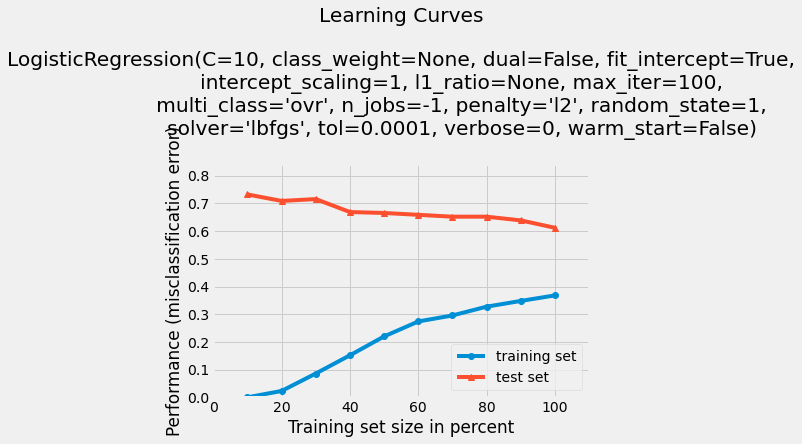

In [551]:
# learning curve plotter for lr
from mlxtend.plotting import plot_learning_curves
lr=LogisticRegression(penalty='l2', n_jobs = -1, random_state=1, C=10, multi_class='ovr', max_iter=100)
plot_learning_curves(pca_title_tag_x_train, y_train, pca_title_tag_x_valid, y_valid, lr)
plt.show()

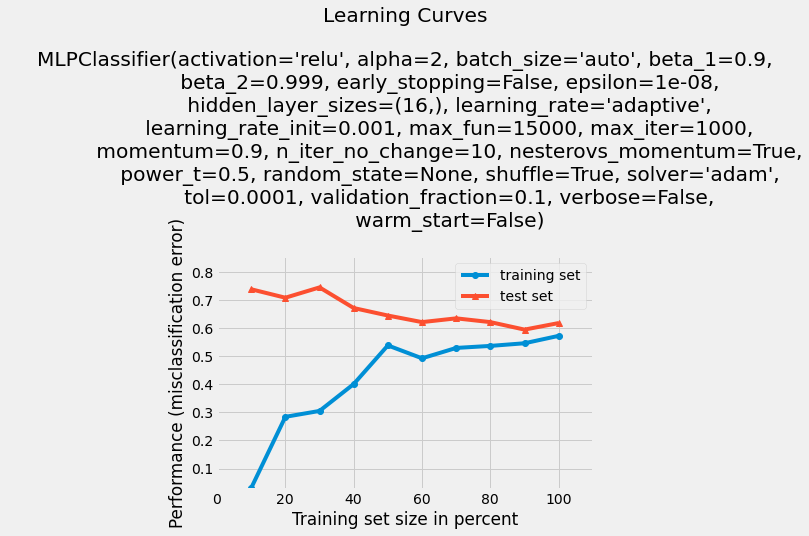

In [550]:
# learning curve plotter for nn
from mlxtend.plotting import plot_learning_curves
mlp = MLPClassifier(solver = 'adam',learning_rate = 'adaptive', hidden_layer_sizes=(16,), alpha=2,max_iter =1000)
plot_learning_curves(pca_title_tag_x_train, y_train, pca_title_tag_x_valid, y_valid, mlp)
plt.show()

In [514]:
from sklearn.metrics import classification_report
lr=LogisticRegression(penalty='l2', n_jobs = -1, random_state=1, C=1, multi_class='ovr')
lr.fit(pca_title_tag_x_train, y_train)
y_test_predict = lr.predict(pca_title_tag_x_test)

In [431]:
from sklearn.metrics import classification_report
mlp = MLPClassifier(solver = 'adam',learning_rate = 'adaptive', hidden_layer_sizes=(512,), alpha=0.8, random_state=1, activation='tanh')
mlp.fit(pca_title_tag_x_train, y_train)
y_predict = mlp.predict(pca_title_tag_x_valid)
print(classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00         6
   Adventure       0.00      0.00      0.00         2
   Animation       0.00      0.00      0.00         3
    Children       0.00      0.00      0.00         3
      Comedy       0.49      0.50      0.49        38
       Crime       0.20      0.20      0.20         5
 Documentary       0.57      0.44      0.50        18
       Drama       0.32      0.53      0.40        43
     Fantasy       0.43      0.33      0.38        18
   Film_Noir       0.00      0.00      0.00         4
      Horror       0.36      0.50      0.42         8
     Musical       0.20      0.10      0.13        10
     Mystery       1.00      0.11      0.20        18
     Romance       0.32      0.39      0.35        51
      Sci_Fi       0.53      0.50      0.52        16
    Thriller       0.34      0.57      0.43        28
         War       0.64      0.33      0.44        21
     Western       0.00    

c:\users\max\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [548]:
from sklearn.dummy import DummyClassifier
dummyClf = DummyClassifier(strategy='stratified', random_state=1)
dummyClf.fit(pca_title_tag_x_train, y_train)
dummyClf.score(pca_title_tag_x_valid, y_valid)

0.11036789297658862